Four Classes Rotating with Expansion V1. Bidimensional.
100 batches of 1187 instances



METHOD: Static lp as classifier
Execution time:  1.6577872180000002
Average error: 76.9367
Average macro-F1: 0.2142289343990619
Average micro-F1: 0.21549999999999997
Acurácia Média:  23.063299999999998
Desvio Padrão:  32.981823389709675
Variância:  1087.8006741100003


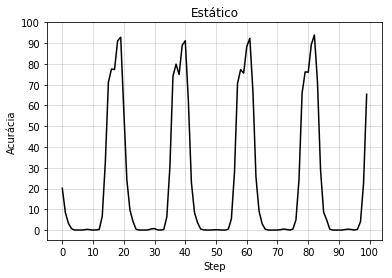

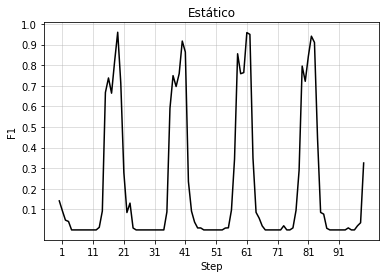




METHOD: Sliding lp as classifier
Execution time:  1.2665037459999997
Average error: 77.8469
Average macro-F1: 0.1070393798696553
Average micro-F1: 0.22390000000000004
Acurácia Média:  22.153099999999995
Desvio Padrão:  10.459067520099484
Variância:  109.39209338999999


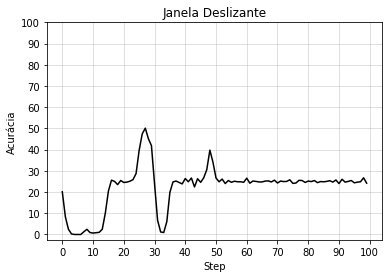

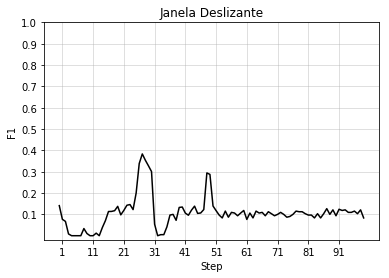




METHOD: Incremental lp as classifier
Execution time:  38.28385928
Average error: 77.8312
Average macro-F1: 0.20535220685291733
Average micro-F1: 0.2071
Acurácia Média:  22.1688
Desvio Padrão:  32.23000689667937
Variância:  1038.7733445599997


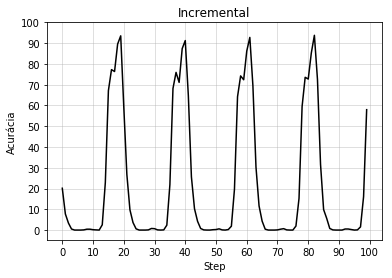

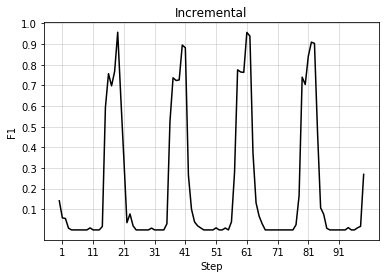




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  7.976813536000002
Average error: 75.785
Average macro-F1: 0.23986472216738974
Average micro-F1: 0.24130000000000001
Acurácia Média:  24.215
Desvio Padrão:  29.51547656738749
Variância:  871.1633570000001


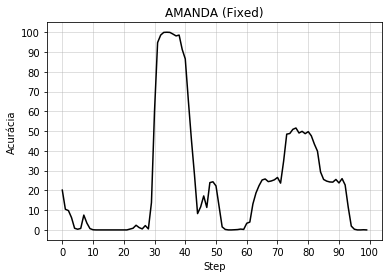

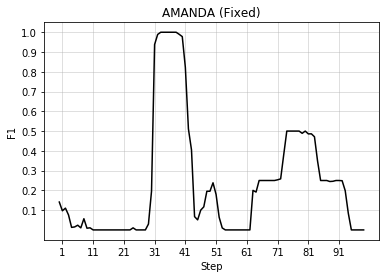




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
AMANDA-DCP Hellinger | Mean keeping percentage=0.26 | Std keeping percentage=0.16
Execution time:  8.008043936999997
Average error: 76.3173
Average macro-F1: 0.19298690774441773
Average micro-F1: 0.2293
Acurácia Média:  23.682699999999997
Desvio Padrão:  26.99863140438789
Variância:  728.92609771


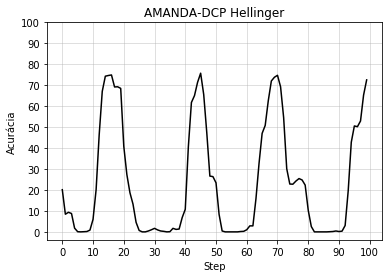

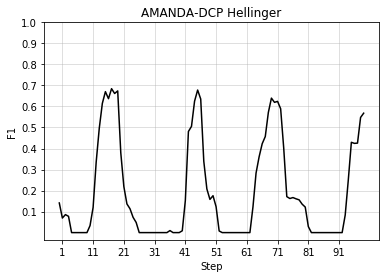




METHOD: lp as classifier and kde and Hellinger2 distance as dynamic CSE
AMANDA-DCP Hellinger2 | Mean keeping percentage=0.27 | Std keeping percentage=0.09
Execution time:  8.120792201
Average error: 77.17020000000001
Average macro-F1: 0.2100860590165545
Average micro-F1: 0.23129999999999998
Acurácia Média:  22.829799999999995
Desvio Padrão:  28.445190770321787
Variância:  809.1288779599997


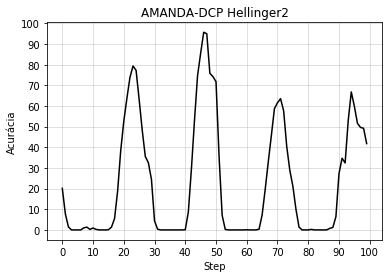

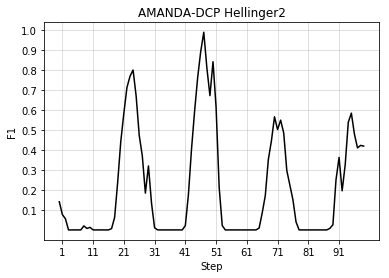




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = -1.000 | Mean keeping percentage=0.20 | Std keeping percentage=0.11
Execution time:  8.060667264999992
Average error: 72.8249
Average macro-F1: 0.2637570645535945
Average micro-F1: 0.2656
Acurácia Média:  27.175099999999997
Desvio Padrão:  39.13454661791803
Variância:  1531.51273899


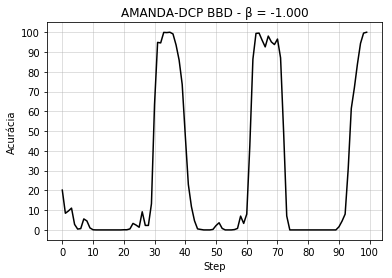

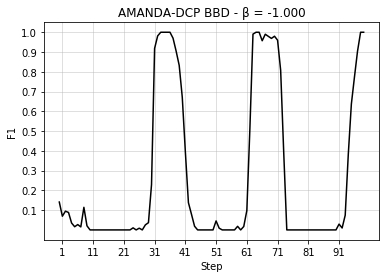

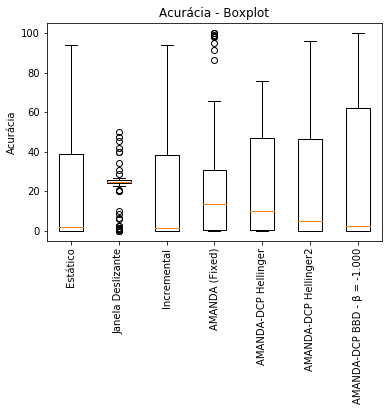

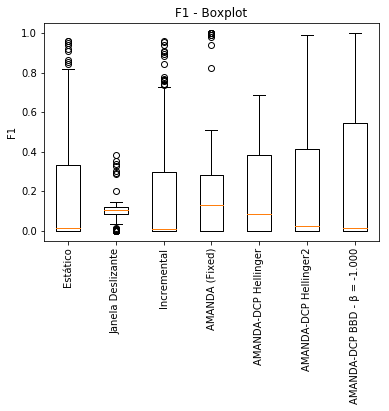

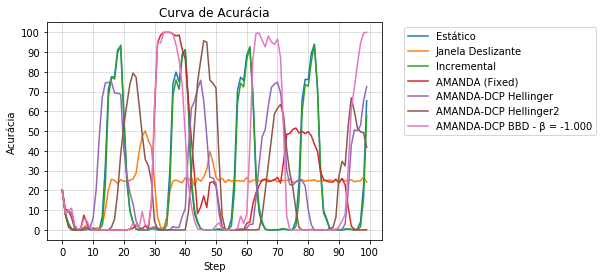

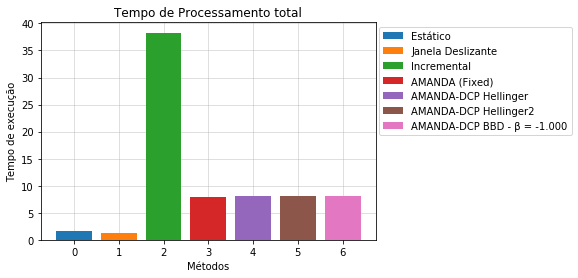

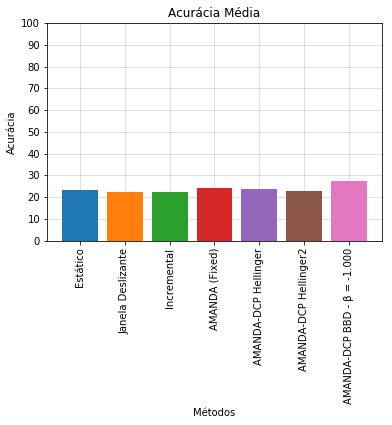

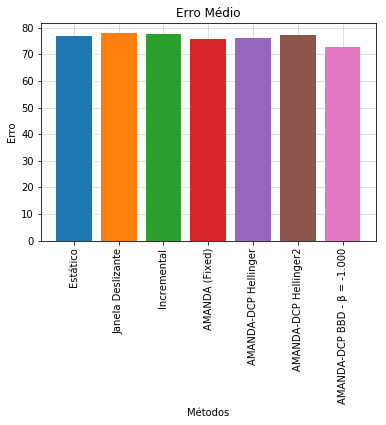

Pos 7 - Redução do Erro (Janela Deslizante):-3.9465297680731
Pos 6 - Redução do Erro (Incremental):-3.8784562486721206
Pos 2 - Redução do Erro (AMANDA (Fixed)):4.993647916820238
Pos 3 - Redução do Erro (AMANDA-DCP Hellinger):2.685652096621034
Pos 5 - Redução do Erro (AMANDA-DCP Hellinger2):-1.0124310051033587
Pos 1 - Redução do Erro (AMANDA-DCP BBD - β = -1.000):17.82832465432093


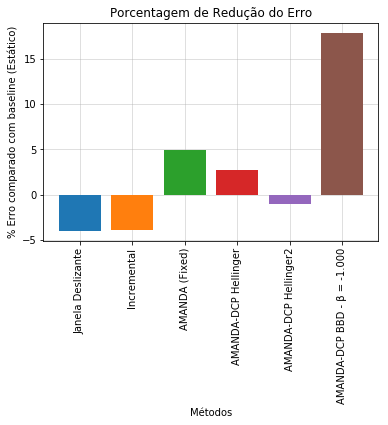

In [1]:
%matplotlib inline
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[4])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None, distanceMetric=None, beta=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K
        self.distanceMetric = distanceMetric
        self.beta = beta


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = False
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.load4CRE_V1(path, sep)
    
    # 5% of initial labeled data
    labeledData = int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 2, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 2, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 2, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 2, 0.85, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - DCP Original)
    experiments[4] = Experiment(amanda_dynamic, 2, None, "kde", sslClassifier, 'Hellinger')
    
    # Proposed method 3 (AMANDA - DCP Hellinger2)
    experiments[5] = Experiment(amanda_dynamic, 2, None, "kde", sslClassifier, 'Hellinger2')                         
    
    # Proposed method 4 (AMANDA - DCP BBD)
    lastIndex = list(experiments.keys())[-1]
    #betas = [-1, 2, 3, 10]
    #bestK = [2, 2, 2, 2]
    betas = [-1]
    bestK = [2]
    for i in range(len(betas)):
        experiments[lastIndex+1+i] = Experiment(amanda_dynamic, bestK[i], None, "kde", sslClassifier, 'BBD', beta=betas[i])
    
    # Proposed method 4 (AMANDA - DCP HDDDM)
    #experiments[17] = Experiment(amanda_dynamic, 2, None, "kde", sslClassifier, 'HDDDM')

    # COMPOSE GMM (Python version)
    #experiments[5] = Experiment(compose_gmm_version, 9)
    
    # levelIw matlab results
    #predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, '4CRE-V1', steps)
    #externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()